In [1]:
import torch
import torchtext
from torch import nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
from perceiver_pytorch import Perceiver
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import itertools
from torch.utils.tensorboard import SummaryWriter
import os
from tqdm.notebook import tqdm
from datetime import datetime
from babi_joint import BabiDataset, pad_collate
from torch.utils.data.dataset import Dataset
from glob import glob
from perceiver_pytorch import PerceiverIObAbInq
import time

In [2]:
# UT pondernet 1470003

model = PerceiverIObAbInq(
    num_tokens=179,
    context_max_seq_len=71*13,
#     question_max_seq_len=13,
    dim = 64,                    # dimension of sequence to be encoded
    queries_dim = 179,            # dimension of decoder queries
    logits_dim = 179,            # dimension of final logits
    depth = 3,                   # depth of net
    num_latents = 32,           # number of latents, or induced set points, or centroids. different papers giving it different names
    latent_dim = 64,            # latent dimension
    cross_heads = 1,             # number of heads for cross attention. paper said 1
    latent_heads = 8,            # number of heads for latent self attention, 8
    cross_dim_head = 64,         # number of dimensions per cross attention head
    latent_dim_head = 64,        # number of dimensions per latent self attention head
    weight_tie_layers = True,   # whether to weight tie layers (optional, as indicated in the diagram)
    self_per_cross_attn = 1,     # number of self attention blocks per cross attention
    learn_latents=True
)

model_name = 'perceiverIO_bAbi_nq_titan'
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

570821


In [3]:
batch_size=128
max_epochs = 150

babi_dataset = BabiDataset(ds_path='/home/gabriel/Documents/datasets/bAbi/en/qa{}_*', 
                           vocab_path='/home/gabriel/Documents/datasets/bAbi/en/babi{}_vocab.pkl')
vocab_size = len(babi_dataset.QA.VOCAB)
print('len(babi_dataset) train', len(babi_dataset))
print('vocab_size', vocab_size)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)
torch.backends.cudnn.benchmark = True
model.to(device)

criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
val_loss_min = float('inf')

writer = SummaryWriter()
if not os.path.isdir(f'checkpoints/{model_name}'):
    os.mkdir(f'checkpoints/{model_name}')
now = datetime.now().strftime("%d_%m_%Y__%H_%M_%S")

for epoch in range(max_epochs):
    train_loss = 0.0
    val_loss = 0.0
    loss_sum = 0
    loss_count = 0
    model.train()
    babi_dataset.set_mode('train')
    train_loader = DataLoader(
        babi_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate
    )
    
    for batch_idx, data in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}/{max_epochs}")):
        optimizer.zero_grad()

        contexts, answers, tasks = data
        contexts = contexts.long().to(device)
#         questions = questions.long().to(device)
        answers = answers.to(device)
        
        logits = torch.squeeze(model(contexts))
        loss = criterion(logits, answers)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        writer.add_scalars("losses_step", {"train_loss": loss.item() / contexts.size(0)}, epoch * len(train_loader) + batch_idx)
    
    train_loss = train_loss / len(train_loader.dataset)
    writer.add_scalars("losses_epoch", {"train_loss": train_loss}, epoch)
    train_loader_len = len(train_loader)
    
    model.eval()
    babi_dataset.set_mode('valid')
    val_loader = DataLoader(
        babi_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate
    )
    
    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader):
        
            contexts, answers, tasks = data
            contexts = contexts.long().to(device)
#             questions = questions.long().to(device)
            answers = answers.to(device)
        
            logits = torch.squeeze(model(contexts))
            loss = criterion(logits, answers)
            val_loss += loss.item()

    val_loss = val_loss / len(val_loader.dataset)
    writer.add_scalars("losses_step", {"val_loss": val_loss}, (epoch + 1) * train_loader_len - 1)    
    writer.add_scalars("losses_epoch", {"val_loss": val_loss}, epoch)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        val_loss
    ))
    
    checkpoint = {
        'epoch': epoch + 1,
        'valid_loss_min': val_loss,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    
    torch.save(checkpoint, f'checkpoints/{model_name}/checkpoint_{now}.pt')
    if val_loss <= val_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(val_loss_min,val_loss))
        torch.save(checkpoint, f'checkpoints/{model_name}/best_checkpoint_{now}.pt')
        val_loss_min = val_loss

len(babi_dataset) train 180000
vocab_size 179
cuda:0


Epoch 1/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 2.526250 	Validation Loss: 1.429245
Validation loss decreased (inf --> 1.429245).  Saving model ...


Epoch 2/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 1.299753 	Validation Loss: 1.188449
Validation loss decreased (1.429245 --> 1.188449).  Saving model ...


Epoch 3/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 1.149817 	Validation Loss: 1.140711
Validation loss decreased (1.188449 --> 1.140711).  Saving model ...


Epoch 4/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 1.108378 	Validation Loss: 1.097344
Validation loss decreased (1.140711 --> 1.097344).  Saving model ...


Epoch 5/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 1.076472 	Validation Loss: 1.072957
Validation loss decreased (1.097344 --> 1.072957).  Saving model ...


Epoch 6/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 1.048298 	Validation Loss: 1.039466
Validation loss decreased (1.072957 --> 1.039466).  Saving model ...


Epoch 7/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 1.024936 	Validation Loss: 1.017887
Validation loss decreased (1.039466 --> 1.017887).  Saving model ...


Epoch 8/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 1.003608 	Validation Loss: 1.003302
Validation loss decreased (1.017887 --> 1.003302).  Saving model ...


Epoch 9/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.983540 	Validation Loss: 0.977406
Validation loss decreased (1.003302 --> 0.977406).  Saving model ...


Epoch 10/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 0.967711 	Validation Loss: 0.970368
Validation loss decreased (0.977406 --> 0.970368).  Saving model ...


Epoch 11/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 11 	Training Loss: 0.953076 	Validation Loss: 0.966324
Validation loss decreased (0.970368 --> 0.966324).  Saving model ...


Epoch 12/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 12 	Training Loss: 0.941202 	Validation Loss: 0.951620
Validation loss decreased (0.966324 --> 0.951620).  Saving model ...


Epoch 13/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 13 	Training Loss: 0.931225 	Validation Loss: 0.943896
Validation loss decreased (0.951620 --> 0.943896).  Saving model ...


Epoch 14/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 14 	Training Loss: 0.922793 	Validation Loss: 0.936681
Validation loss decreased (0.943896 --> 0.936681).  Saving model ...


Epoch 15/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 15 	Training Loss: 0.914268 	Validation Loss: 0.927033
Validation loss decreased (0.936681 --> 0.927033).  Saving model ...


Epoch 16/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 16 	Training Loss: 0.902785 	Validation Loss: 0.909163
Validation loss decreased (0.927033 --> 0.909163).  Saving model ...


Epoch 17/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 17 	Training Loss: 0.888545 	Validation Loss: 0.891337
Validation loss decreased (0.909163 --> 0.891337).  Saving model ...


Epoch 18/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 18 	Training Loss: 0.877864 	Validation Loss: 0.891619


Epoch 19/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 19 	Training Loss: 0.867691 	Validation Loss: 0.884482
Validation loss decreased (0.891337 --> 0.884482).  Saving model ...


Epoch 20/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 20 	Training Loss: 0.858095 	Validation Loss: 0.879050
Validation loss decreased (0.884482 --> 0.879050).  Saving model ...


Epoch 21/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 21 	Training Loss: 0.850860 	Validation Loss: 0.867945
Validation loss decreased (0.879050 --> 0.867945).  Saving model ...


Epoch 22/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 22 	Training Loss: 0.841927 	Validation Loss: 0.863253
Validation loss decreased (0.867945 --> 0.863253).  Saving model ...


Epoch 23/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 23 	Training Loss: 0.833976 	Validation Loss: 0.862534
Validation loss decreased (0.863253 --> 0.862534).  Saving model ...


Epoch 24/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 24 	Training Loss: 0.825718 	Validation Loss: 0.850377
Validation loss decreased (0.862534 --> 0.850377).  Saving model ...


Epoch 25/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 25 	Training Loss: 0.818140 	Validation Loss: 0.849406
Validation loss decreased (0.850377 --> 0.849406).  Saving model ...


Epoch 26/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 26 	Training Loss: 0.812605 	Validation Loss: 0.846621
Validation loss decreased (0.849406 --> 0.846621).  Saving model ...


Epoch 27/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 27 	Training Loss: 0.804816 	Validation Loss: 0.839024
Validation loss decreased (0.846621 --> 0.839024).  Saving model ...


Epoch 28/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 28 	Training Loss: 0.798980 	Validation Loss: 0.840212


Epoch 29/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 29 	Training Loss: 0.792733 	Validation Loss: 0.841336


Epoch 30/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 30 	Training Loss: 0.786394 	Validation Loss: 0.836552
Validation loss decreased (0.839024 --> 0.836552).  Saving model ...


Epoch 31/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 31 	Training Loss: 0.780431 	Validation Loss: 0.843106


Epoch 32/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 32 	Training Loss: 0.775566 	Validation Loss: 0.845133


Epoch 33/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 33 	Training Loss: 0.769498 	Validation Loss: 0.832801
Validation loss decreased (0.836552 --> 0.832801).  Saving model ...


Epoch 34/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 34 	Training Loss: 0.764305 	Validation Loss: 0.836955


Epoch 35/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 35 	Training Loss: 0.757988 	Validation Loss: 0.835583


Epoch 36/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 36 	Training Loss: 0.751617 	Validation Loss: 0.826554
Validation loss decreased (0.832801 --> 0.826554).  Saving model ...


Epoch 37/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 37 	Training Loss: 0.745847 	Validation Loss: 0.832516


Epoch 38/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 38 	Training Loss: 0.737356 	Validation Loss: 0.837930


Epoch 39/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 39 	Training Loss: 0.729346 	Validation Loss: 0.838199


Epoch 40/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 40 	Training Loss: 0.721434 	Validation Loss: 0.837935


Epoch 41/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 41 	Training Loss: 0.714591 	Validation Loss: 0.837778


Epoch 42/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 42 	Training Loss: 0.708654 	Validation Loss: 0.844601


Epoch 43/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 43 	Training Loss: 0.700818 	Validation Loss: 0.841622


Epoch 44/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 44 	Training Loss: 0.694741 	Validation Loss: 0.846202


Epoch 45/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 45 	Training Loss: 0.686488 	Validation Loss: 0.855756


Epoch 46/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 46 	Training Loss: 0.681124 	Validation Loss: 0.871209


Epoch 47/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 47 	Training Loss: 0.672645 	Validation Loss: 0.868326


Epoch 48/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 48 	Training Loss: 0.666462 	Validation Loss: 0.876530


Epoch 49/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 49 	Training Loss: 0.659787 	Validation Loss: 0.890957


Epoch 50/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 50 	Training Loss: 0.652023 	Validation Loss: 0.897185


Epoch 51/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 51 	Training Loss: 0.644918 	Validation Loss: 0.905734


Epoch 52/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 52 	Training Loss: 0.637614 	Validation Loss: 0.904766


Epoch 53/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 53 	Training Loss: 0.631056 	Validation Loss: 0.914534


Epoch 54/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 54 	Training Loss: 0.622984 	Validation Loss: 0.925528


Epoch 55/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 55 	Training Loss: 0.616333 	Validation Loss: 0.939277


Epoch 56/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 56 	Training Loss: 0.609968 	Validation Loss: 0.950061


Epoch 57/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 57 	Training Loss: 0.601989 	Validation Loss: 0.961676


Epoch 58/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 58 	Training Loss: 0.594020 	Validation Loss: 0.973017


Epoch 59/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 59 	Training Loss: 0.588441 	Validation Loss: 0.995374


Epoch 60/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 60 	Training Loss: 0.581412 	Validation Loss: 0.999703


Epoch 61/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 61 	Training Loss: 0.571689 	Validation Loss: 1.012238


Epoch 62/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 62 	Training Loss: 0.567950 	Validation Loss: 1.023361


Epoch 63/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 63 	Training Loss: 0.559531 	Validation Loss: 1.042435


Epoch 64/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 64 	Training Loss: 0.554030 	Validation Loss: 1.058673


Epoch 65/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 65 	Training Loss: 0.547518 	Validation Loss: 1.078215


Epoch 66/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 66 	Training Loss: 0.540456 	Validation Loss: 1.097697


Epoch 67/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 67 	Training Loss: 0.535292 	Validation Loss: 1.112121


Epoch 68/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 68 	Training Loss: 0.529580 	Validation Loss: 1.100596


Epoch 69/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 69 	Training Loss: 0.521022 	Validation Loss: 1.141637


Epoch 70/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 70 	Training Loss: 0.516615 	Validation Loss: 1.130270


Epoch 71/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 71 	Training Loss: 0.508480 	Validation Loss: 1.167942


Epoch 72/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 72 	Training Loss: 0.503620 	Validation Loss: 1.167498


Epoch 73/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 73 	Training Loss: 0.497416 	Validation Loss: 1.206512


Epoch 74/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 74 	Training Loss: 0.492532 	Validation Loss: 1.213297


Epoch 75/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 75 	Training Loss: 0.484991 	Validation Loss: 1.206620


Epoch 76/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 76 	Training Loss: 0.479264 	Validation Loss: 1.245829


Epoch 77/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 77 	Training Loss: 0.474600 	Validation Loss: 1.257191


Epoch 78/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 78 	Training Loss: 0.469183 	Validation Loss: 1.274094


Epoch 79/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 79 	Training Loss: 0.464202 	Validation Loss: 1.285652


Epoch 80/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 80 	Training Loss: 0.462097 	Validation Loss: 1.305879


Epoch 81/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 81 	Training Loss: 0.452363 	Validation Loss: 1.330246


Epoch 82/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 82 	Training Loss: 0.449911 	Validation Loss: 1.356012


Epoch 83/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 83 	Training Loss: 0.445206 	Validation Loss: 1.341773


Epoch 84/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 84 	Training Loss: 0.438362 	Validation Loss: 1.370113


Epoch 85/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 85 	Training Loss: 0.433271 	Validation Loss: 1.407534


Epoch 86/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 86 	Training Loss: 0.430584 	Validation Loss: 1.427615


Epoch 87/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 87 	Training Loss: 0.425570 	Validation Loss: 1.431195


Epoch 88/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 88 	Training Loss: 0.422356 	Validation Loss: 1.440663


Epoch 89/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 89 	Training Loss: 0.416925 	Validation Loss: 1.446865


Epoch 90/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 90 	Training Loss: 0.410445 	Validation Loss: 1.455282


Epoch 91/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 91 	Training Loss: 0.408439 	Validation Loss: 1.492264


Epoch 92/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 92 	Training Loss: 0.404266 	Validation Loss: 1.497205


Epoch 93/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 93 	Training Loss: 0.400964 	Validation Loss: 1.531564


Epoch 94/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 94 	Training Loss: 0.397243 	Validation Loss: 1.547148


Epoch 95/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 95 	Training Loss: 0.393438 	Validation Loss: 1.544879


Epoch 96/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 96 	Training Loss: 0.390701 	Validation Loss: 1.580074


Epoch 97/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 97 	Training Loss: 0.387502 	Validation Loss: 1.564113


Epoch 98/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 98 	Training Loss: 0.382080 	Validation Loss: 1.590793


Epoch 99/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 99 	Training Loss: 0.376367 	Validation Loss: 1.604685


Epoch 100/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 100 	Training Loss: 0.377446 	Validation Loss: 1.622111


Epoch 101/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 101 	Training Loss: 0.373912 	Validation Loss: 1.629397


Epoch 102/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 102 	Training Loss: 0.366278 	Validation Loss: 1.626231


Epoch 103/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 103 	Training Loss: 0.367605 	Validation Loss: 1.658694


Epoch 104/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 104 	Training Loss: 0.360631 	Validation Loss: 1.696863


Epoch 105/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 105 	Training Loss: 0.359043 	Validation Loss: 1.655725


Epoch 106/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 106 	Training Loss: 0.360784 	Validation Loss: 1.697315


Epoch 107/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 107 	Training Loss: 0.353800 	Validation Loss: 1.682790


Epoch 108/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 108 	Training Loss: 0.353299 	Validation Loss: 1.721699


Epoch 109/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 109 	Training Loss: 0.347996 	Validation Loss: 1.744045


Epoch 110/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 110 	Training Loss: 0.345503 	Validation Loss: 1.745159


Epoch 111/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 111 	Training Loss: 0.344537 	Validation Loss: 1.761018


Epoch 112/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 112 	Training Loss: 0.341720 	Validation Loss: 1.767769


Epoch 113/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 113 	Training Loss: 0.338424 	Validation Loss: 1.771996


Epoch 114/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 114 	Training Loss: 0.336296 	Validation Loss: 1.797171


Epoch 115/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 115 	Training Loss: 0.333077 	Validation Loss: 1.805627


Epoch 116/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 116 	Training Loss: 0.330492 	Validation Loss: 1.837164


Epoch 117/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 117 	Training Loss: 0.327256 	Validation Loss: 1.840837


Epoch 118/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 118 	Training Loss: 0.325335 	Validation Loss: 1.836341


Epoch 119/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 119 	Training Loss: 0.327027 	Validation Loss: 1.857078


Epoch 120/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 120 	Training Loss: 0.322265 	Validation Loss: 1.842436


Epoch 121/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 121 	Training Loss: 0.318584 	Validation Loss: 1.867865


Epoch 122/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 122 	Training Loss: 0.314901 	Validation Loss: 1.903447


Epoch 123/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 123 	Training Loss: 0.326472 	Validation Loss: 1.847302


Epoch 124/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 124 	Training Loss: 0.311456 	Validation Loss: 1.938946


Epoch 125/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 125 	Training Loss: 0.311342 	Validation Loss: 1.927406


Epoch 126/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 126 	Training Loss: 0.308361 	Validation Loss: 1.948952


Epoch 127/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 127 	Training Loss: 0.309660 	Validation Loss: 1.956995


Epoch 128/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 128 	Training Loss: 0.306419 	Validation Loss: 1.959743


Epoch 129/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 129 	Training Loss: 0.301447 	Validation Loss: 1.963287


Epoch 130/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 130 	Training Loss: 0.302573 	Validation Loss: 1.980765


Epoch 131/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 131 	Training Loss: 0.299991 	Validation Loss: 2.003787


Epoch 132/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 132 	Training Loss: 0.298212 	Validation Loss: 2.002394


Epoch 133/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 133 	Training Loss: 0.296126 	Validation Loss: 2.008741


Epoch 134/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 134 	Training Loss: 0.295165 	Validation Loss: 2.001369


Epoch 135/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 135 	Training Loss: 0.293175 	Validation Loss: 2.023726


Epoch 136/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 136 	Training Loss: 0.289190 	Validation Loss: 2.047539


Epoch 137/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 137 	Training Loss: 0.290752 	Validation Loss: 2.049980


Epoch 138/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 138 	Training Loss: 0.285483 	Validation Loss: 2.066995


Epoch 139/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 139 	Training Loss: 0.286417 	Validation Loss: 2.091948


Epoch 140/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 140 	Training Loss: 0.280975 	Validation Loss: 2.110638


Epoch 141/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 141 	Training Loss: 0.283975 	Validation Loss: 2.093436


Epoch 142/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 142 	Training Loss: 0.283791 	Validation Loss: 2.090732


Epoch 143/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 143 	Training Loss: 0.282181 	Validation Loss: 2.092156


Epoch 144/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 144 	Training Loss: 0.277054 	Validation Loss: 2.087458


Epoch 145/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 145 	Training Loss: 0.274172 	Validation Loss: 2.143371


Epoch 146/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 146 	Training Loss: 0.273793 	Validation Loss: 2.133702


Epoch 147/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 147 	Training Loss: 0.274119 	Validation Loss: 2.120844


Epoch 148/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 148 	Training Loss: 0.267928 	Validation Loss: 2.155753


Epoch 149/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 149 	Training Loss: 0.273639 	Validation Loss: 2.154136


Epoch 150/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 150 	Training Loss: 0.262805 	Validation Loss: 2.159454


cuda:0


Inference:   0%|          | 0/157 [00:00<?, ?it/s]

/home/gabriel/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gabriel/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gabriel/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gabriel/miniconda3/lib/pyth

0.6243
                     precision    recall  f1-score   support

              apple       0.85      0.69      0.76       341
     apple,football       0.00      0.00      0.00        11
apple,football,milk       0.00      0.00      0.00         1
         apple,milk       0.00      0.00      0.00        10
           bathroom       0.65      0.59      0.62      1195
            bedroom       0.66      0.57      0.61      1437
               bill       0.39      0.46      0.42       164
              bored       1.00      1.00      1.00       159
                cat       0.50      0.89      0.64       213
             cinema       0.39      0.58      0.47       171
                e,e       0.11      0.19      0.14        81
                e,n       0.17      0.02      0.04        88
                e,s       0.07      0.24      0.11        79
           football       0.69      0.78      0.73       281
     football,apple       0.00      0.00      0.00        18
football,apple,m

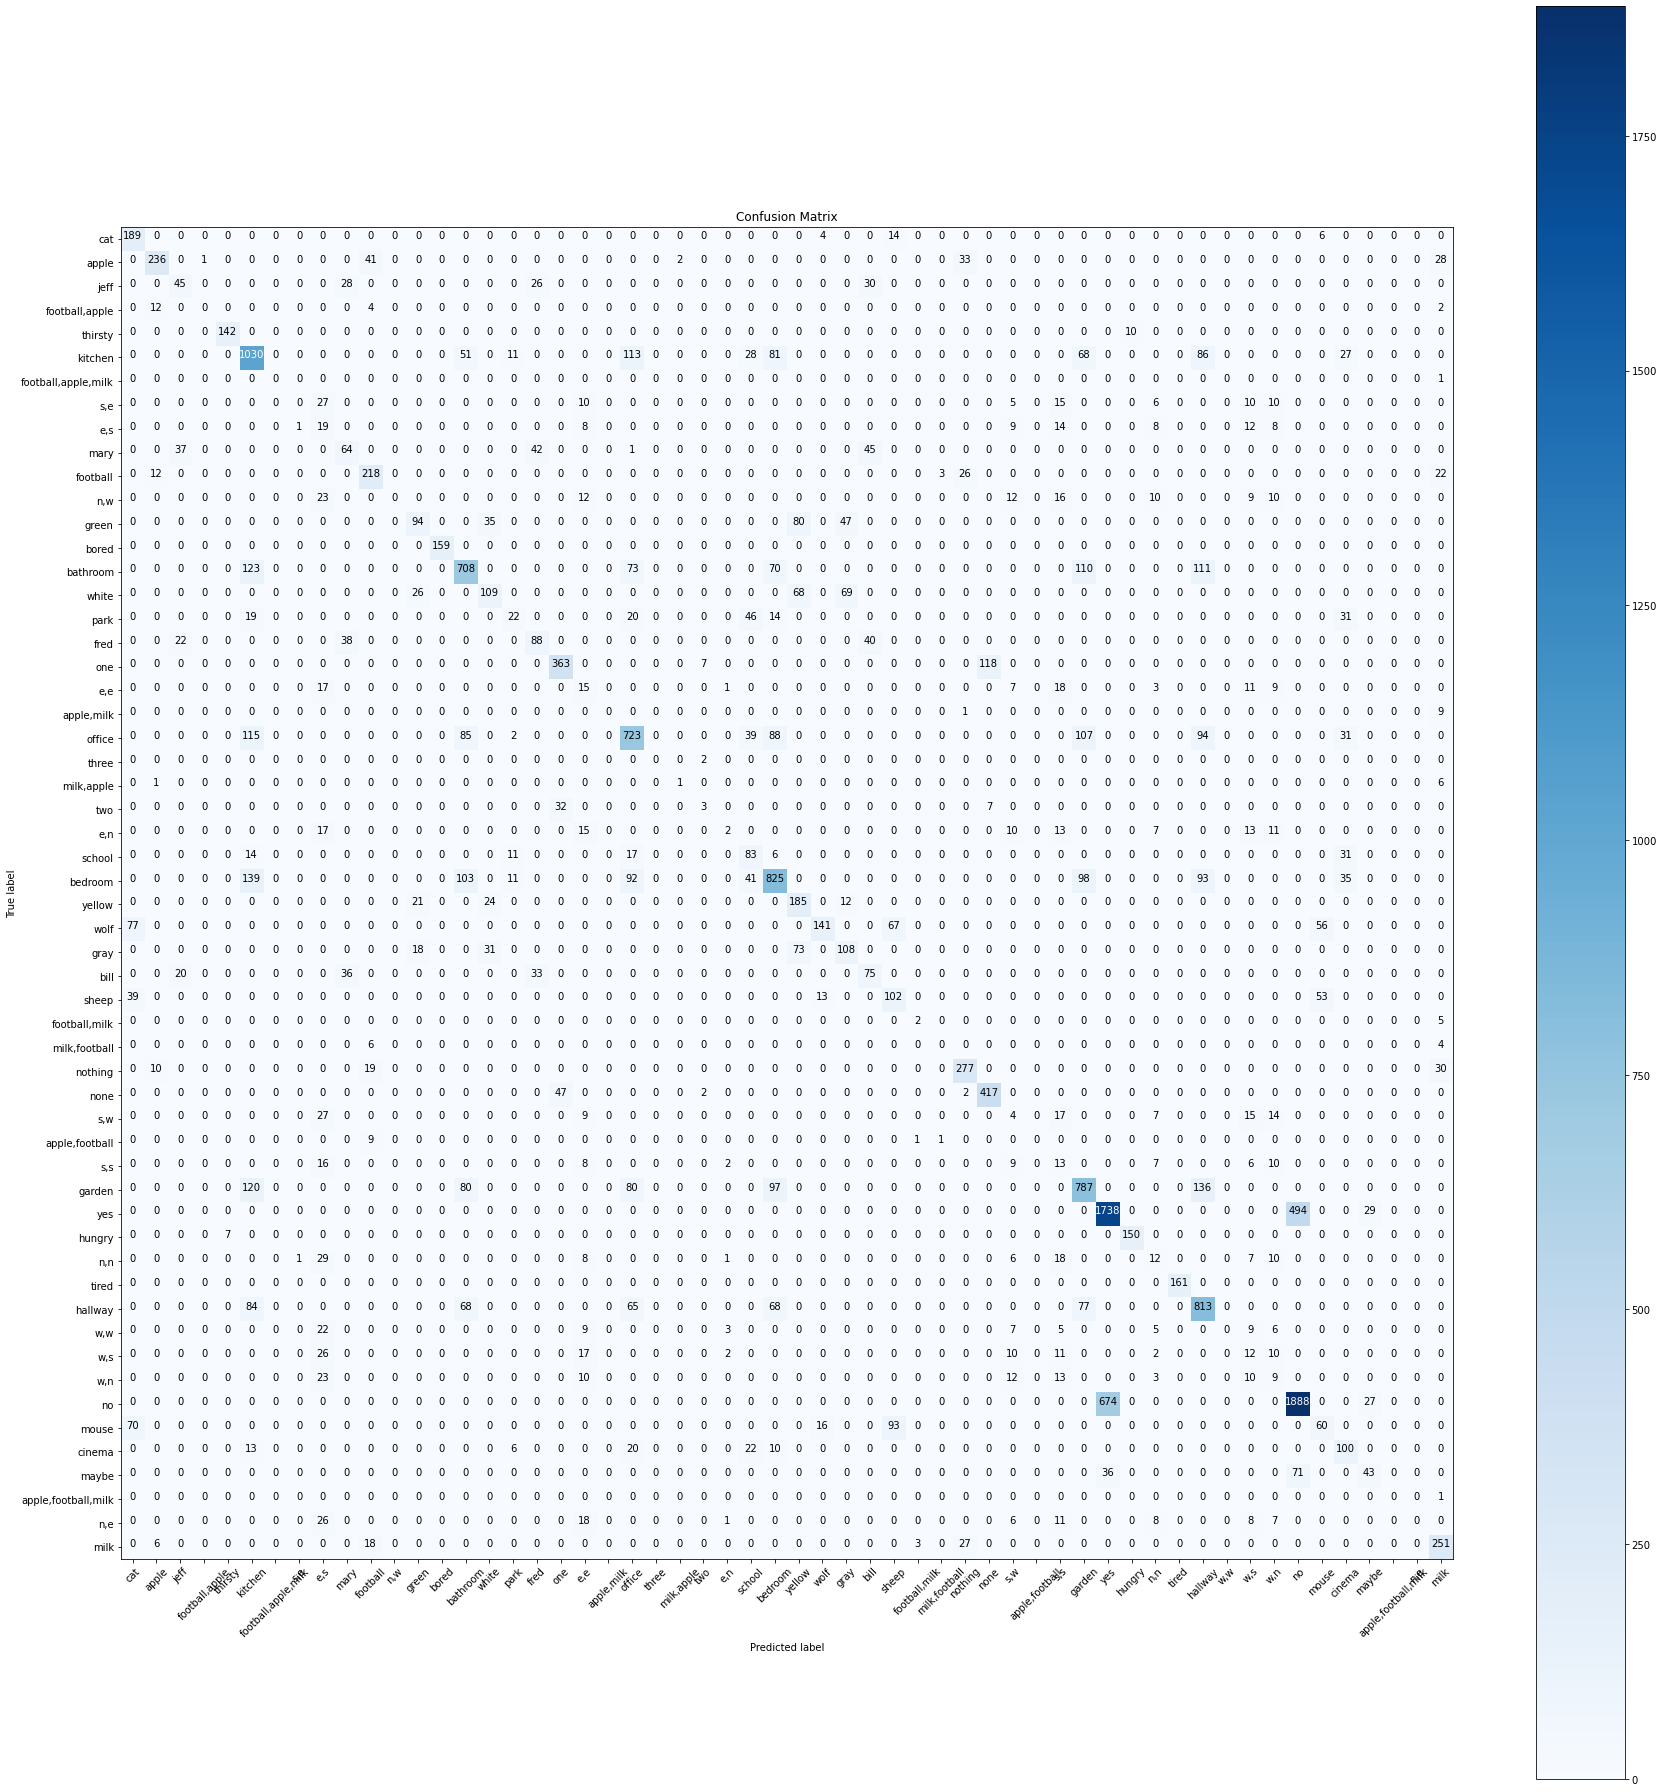

2.120548963546753


In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)
model.to(device)
checkpoint_name = f'checkpoints/{model_name}/best_checkpoint_{now}.pt'
checkpoint = torch.load(checkpoint_name)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
m = nn.Softmax(dim=1)

babi_dataset.set_mode('test')
test_loader = DataLoader(
    babi_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate
)

y_pred_extended = []
y_true_extended = []
y_pred_task = [[] for _ in range(20)]
y_true_task = [[] for _ in range(20)]

start = time.time()
with torch.no_grad():
    for batch_idx, data in enumerate(tqdm(test_loader, desc=f"Inference")):
        contexts, answers, tasks = data
        contexts = contexts.long().to(device)
#         questions = questions.long().to(device)
        answers = answers.to(device)

        logits = torch.squeeze(model(contexts)).cpu()
        # We consider a task successfully passed if ≥ 95% accuracy is obtained.
        y_pred = m(logits)
        y_pred = np.argmax(y_pred, axis=1)
        y_pred = [babi_dataset.QA.IVOCAB[int(i)] for i in y_pred]
        y_true = [babi_dataset.QA.IVOCAB[int(i)] for i in answers.cpu()]
        y_pred_extended.extend(y_pred)
        y_true_extended.extend(y_true)
        for i in range(len(y_pred)):
            y_pred_task[int(tasks[i]) - 1].append(y_pred[i])
            y_true_task[int(tasks[i]) - 1].append(y_true[i])
end = time.time()

        
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)
    
    plt.figure(figsize=(25,25))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

accuracy = accuracy_score(y_pred_extended, y_true_extended)
cr = classification_report(y_true_extended, y_pred_extended)
print(accuracy)
print(cr)
task_acc = []
passed_tasks = []
for i in range(20):
    task_acc.append(accuracy_score(y_pred_task[i], y_true_task[i]))
    passed_tasks.append(1 if task_acc[i] >= 0.95 else 0)
print(task_acc)
print('passed_tasks:', passed_tasks)
print('no. passed_tasks:', sum(passed_tasks))
labels = list(set(y_true_extended).intersection(set(y_true_extended)))
cnf_matrix = confusion_matrix(y_true_extended, y_pred_extended, labels)
# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=labels, title = ('Confusion Matrix'))
plt.show()
print(end-start)

In [ ]:
# from thop import profile
# from thop import clever_format

# macs, params = profile(model, inputs=(
#                         torch.randint(1, size=(1, 910)).type(torch.LongTensor).to(device), 
#                         torch.randint(1, size=(1, 13)).type(torch.LongTensor).to(device)))  # , 
# #                         custom_ops={YourModule: count_your_model})

# macs, params = clever_format([macs, params], "%.3f")
# print(macs, params)

In [ ]:
# model.layers.append(model.layers[1])
print(len(model.layers))